In [1]:
%matplotlib inline
import numpy as np
import decimal
import matplotlib.pyplot as plt
from scipy import interpolate as intp
from scipy import stats
import seaborn as sns
from itertools import compress
from matplotlib.pyplot import cm
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import *

import torch
import torchvision
import torchvision.transforms as transforms

import cv2
from scipy.io import loadmat
from scipy.io import savemat
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def Extract_Orientation_Contrast(frame, ksize, sigma_o, sigma_c, rs):
    """
    Function that estimates the local orientation and contrast at each pixel in the input image frame.
    Inputs:
    frame   - input image
    ksize   - kernel size of the gaussian kernel used to smooth the squared gradients
    sigma_o - standard deviation of the gaussian kernel for estimating orientations
    sigma_c - standard deviation of the gaussian kernel for estimating orientations
    rs      - factor by which to resize the gradient functions
    
    Outputs: 
    Ohat  - estimated orientation
    Chat  - estimated contrast
    """

    # First, compute the gradients
    gx = frame[:,1:] - frame[:,0:-1]
    gx = np.concatenate((gx,np.expand_dims(gx[:,-1],axis=1)),axis=1)

    gy = frame[1:,:] - frame[0:-1,:]
    gy = np.concatenate((gy,np.expand_dims(gy[-1,:],axis=0)),axis=0)

    gxx = gx**2
    gyy = gy**2
    gxy = gx*gy

    # smoothen these sqaured gradients if needed
    gxx = cv2.GaussianBlur(gxx,(ksize,ksize),sigma_o)
    gyy = cv2.GaussianBlur(gyy,(ksize,ksize),sigma_o)
    gxy = cv2.GaussianBlur(gxy,(ksize,ksize),sigma_o)

    # resize these gradient functions
    if rs != 1:
        gxx = cv2.resize(gxx,None,fx=rs, fy=rs, interpolation = cv2.INTER_LANCZOS4)
        gyy = cv2.resize(gyy,None,fx=rs, fy=rs, interpolation = cv2.INTER_LANCZOS4)
        gxy = cv2.resize(gxy,None,fx=rs, fy=rs, interpolation = cv2.INTER_LANCZOS4)

    # Compute local orientations
    Ohat = np.zeros(gxx.shape)

    for i in range(gxx.shape[0]):
        for j in range(gxx.shape[1]):
            M = np.array([[gxx[i,j],gxy[i,j]],[gxy[i,j],gyy[i,j]]])
            D, V = np.linalg.eig(M)
            if D[0] >D[1]:
                ind = 0
            else:
                ind = 1
            Ohat[i,j] = np.arctan2(V[1,ind],V[0,ind])

    # Align the orientation such that 0 radians is north, pi/2 is west and pi is south
    Ohat = np.mod(-Ohat,np.pi)

    Chat = np.sqrt(gx**2 + gy**2)
    Chat = cv2.GaussianBlur(Chat,(ksize,ksize),sigma_c)
    if rs != 1:
        Chat = cv2.resize(Chat,None,fx=rs, fy=rs, interpolation = cv2.INTER_LANCZOS4)
    
    return Ohat, Chat

In [3]:
def ProcessCIFAR(image, rs):
    """
    Extract local contrast and orientations
    1. Reshape CIFAR image of size 32x32x3 to 27x27x3. This is because we choose a 9x9 grid of pixels as the visual field of the mouse.
    2. Convert image to grayscale and upsample to compute gradients
    3. Extract local contrast and orientation
    4. Downsample local contrast and orientation maps from 27x27 to 9x9
    """
    # 1. Reshape CIFAR image of size 32x32x3 to 27x27x3
    image = image[2:29,2:29,:]
    
    # 2. Convert image to grayscale and upsample by rs
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image,None,fx=rs, fy=rs, interpolation = cv2.INTER_LANCZOS4)
    
    # 3. Extract local orientation and contrast. Outputs are downsampled by 1/rs
    ksize = 25
    sigma_o = 10
    sigma_c = 15
    Ohat, Chat = Extract_Orientation_Contrast(np.double(image), ksize, sigma_o, sigma_c, 1.0/rs)

    # 4. Further downsample by a factor of 3
    Ohat = cv2.resize(Ohat,None,fx=1/3, fy=1/3, interpolation = cv2.INTER_LANCZOS4)
    Chat = cv2.resize(Chat,None,fx=1/3, fy=1/3, interpolation = cv2.INTER_LANCZOS4)
    
    return Ohat, Chat


In [4]:
# Extract the CIFAR image data. Download if necessary

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./Cifar_data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=4,
#                                          shuffle=False, num_workers=2)

#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print('Size of dataset = ',trainset.train_data.shape)

Files already downloaded and verified
Size of dataset =  (50000, 32, 32, 3)


In [5]:
len(trainset.train_data)

50000

In [14]:
imgdata = []
for k in tqdm(range(len(trainset.train_data))):
    img = trainset.train_data[k,:,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,None,fx=2, fy=2, interpolation = cv2.INTER_LANCZOS4)
    imgdata.append(img)
imgdata = np.asarray(imgdata)

100%|██████████| 50000/50000 [00:04<00:00, 10458.09it/s]


In [31]:
# Compute fourier transform of the data
F_imgdata = np.fft.fft2(imgdata - 127.5)


In [32]:
# compute average magnitude response
Fdata = np.fft.fftshift(np.mean(np.abs(F_imgdata),axis=0))

In [36]:
Fdata2 = np.fft.fftshift(np.abs(np.mean(F_imgdata,axis=0)))

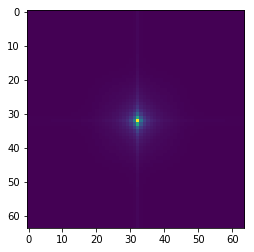

In [43]:
plt.imshow(Fdata)

In [6]:
trainset.train_labels

6

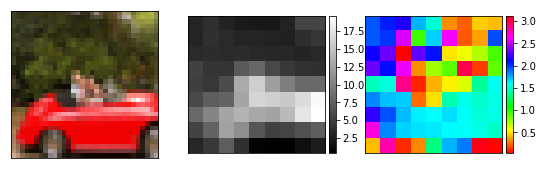

In [5]:
# Example first stage of processing
image = trainset.train_data[99,:,:,:]

Ohat, Chat = ProcessCIFAR(image, 4)

# Plot example image, estimated orientation and orientation maps
fig, axes = plt.subplots(1,3,figsize=[9,5])

axes[0].imshow(image,cmap='gray')
axes[0].set_xticks([]); axes[0].set_yticks([])

im = axes[1].imshow(Chat,cmap='gray')
axes[1].set_xticks([]); axes[1].set_yticks([])
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[2].imshow(Ohat,cmap='hsv')
axes[2].set_xticks([]); axes[2].set_yticks([])
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

In [6]:
# Now extract local orientation and contrast for all the images
Nimages = trainset.train_data.shape[0]
# Nimages = 100
OhatReq = np.zeros([Nimages,9,9])
ChatReq = np.zeros([Nimages,9,9])

for k in range(Nimages):
    image = trainset.train_data[k,:,:,:]
    Ohat, Chat = ProcessCIFAR(image, 4)
    OhatReq[k,:,:] = Ohat
    ChatReq[k,:,:] = Chat
    if np.mod(k,5000) == 0:
        print(k)
    

0
5000
10000
15000
20000
25000
30000
35000
40000
45000


In [7]:
# Quantize OhatReq and ChatReq
OhatReq = np.uint8(np.floor(256*OhatReq/np.pi))
ChatReq = np.uint8(np.floor(256*ChatReq/np.max(ChatReq)))

In [8]:
# Save OhatReq and ChatReq
mdict = {'OMapReq': OhatReq, 'CMapReq': ChatReq}
fname = './Platinum_mouse_GNN_data/EstimatedCIFARFeatures.mat'
savemat(fname, mdict)